<a href="https://colab.research.google.com/github/DPK-VT/MLTESTS/blob/main/Currency_ECBTest4_W180_REV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['Date', 'EUR/USD', 'EUR/JPY', 'EUR/GBP', 'EUR/CHF', 'EUR/AUD'], dtype='object')
Epoch 1/100
143/143 - 14s - 98ms/step - loss: 0.0408 - val_loss: 0.0015 - learning_rate: 1.0000e-03
Epoch 2/100
143/143 - 11s - 78ms/step - loss: 0.0077 - val_loss: 0.0012 - learning_rate: 1.0000e-03
Epoch 3/100
143/143 - 21s - 144ms/step - loss: 0.0059 - val_loss: 5.2725e-04 - learning_rate: 1.0000e-03
Epoch 4/100
143/143 - 11s - 79ms/step - loss: 0.0047 - val_loss: 3.9229e-04 - learning_rate: 1.0000e-03
Epoch 5/100
143/143 - 21s - 150ms/step - loss: 0.0042 - val_loss: 3.5181e-04 - learning_rate: 1.0000e-03
Epoch 6/100
143/143 - 19s - 136ms/step - loss: 0.0037 - val_loss: 3.3721e-04 - learning_rate: 1.0000e-03
Epoch 7/100
143/143 - 11s - 78ms/step - loss: 0.0034 - val_loss: 3.3774e-04 - learning_rate: 1.0000e-03
Epoch 8/100
143/143 - 11s - 79ms/step - loss: 0.0031 - val_loss: 3.9089e-04 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.000500000023748725

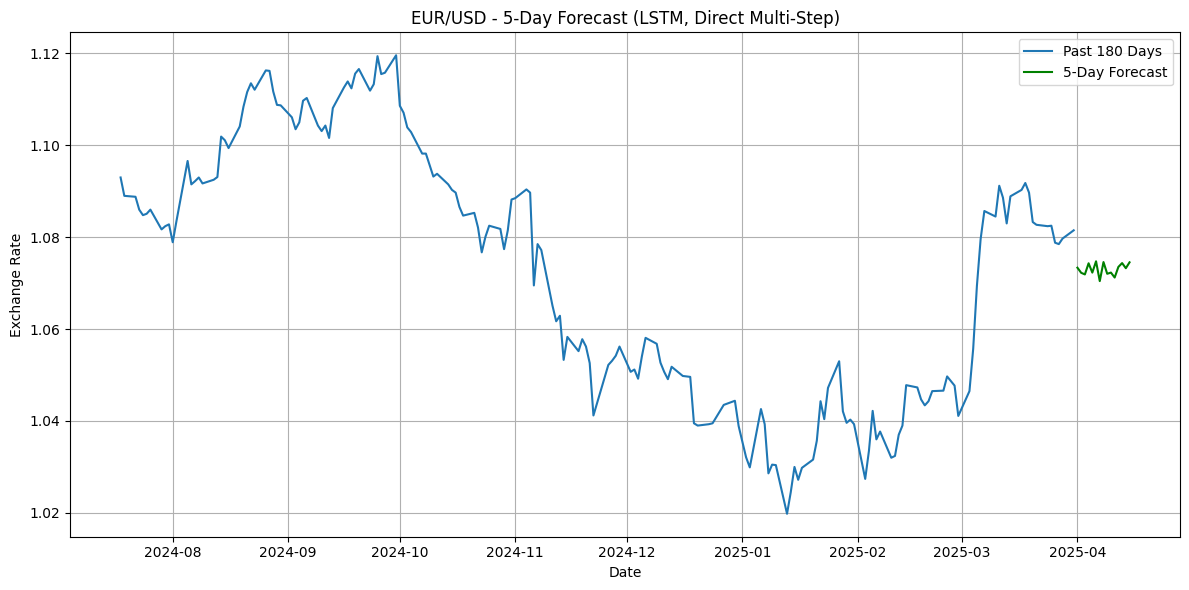

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Read Excel file
df = pd.read_excel('ECB_exchange_rates_march31.xlsx', engine='openpyxl')  # Replace with the exact filename
print(df.columns)
# Renaming the column for EUR/USD exchange rate
#df = df.rename(columns={'USD': 'EUR/USD'})  # Adjust according to your dataset

# Set the 'Date' column as index and sort it
#df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Make sure the date format matches your data
#df.set_index('Date', inplace=True)
#df.sort_index(inplace=True)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

#select currency
currency = 'EUR/USD'  # Change this to one of: 'EUR/USD', 'EUR/JPY', 'EUR/GBP', 'EUR/CHF', 'EUR/AUD'
data = df[[currency]].copy()
data = data.dropna()

# Scaling the data MinMax
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[[currency]])

# Create the dataset with a 90-day window size

def create_sequences_multi_output(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

window_size = 180
forecast_horizon = 15
X, y = create_sequences_multi_output(scaled_data, window_size, forecast_horizon)

# --- Train/val/test split ---
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# --- Reshape for LSTM ---
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_val = X_val.reshape((X_val.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

# Train/val/test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# --- Define model ---
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(forecast_horizon)
])
model.compile(optimizer='adam', loss='mse')

# --- Train model with callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

#forecast
forecast_input = X_test[-1].reshape(1, window_size, 1)
forecast = model.predict(forecast_input)[0]  # Shape: (15,)

forecast = scaler.inverse_transform(forecast.reshape(-1, 1))

# --- Forecast dates ---
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)

# Save the model and scaler
model.save(f"{currency.replace('/', '_')}_lstm_model.keras")
joblib.dump(scaler, f"{currency.replace('/', '_')}_scaler.pkl")

# Plotting the loss curves
# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(data.index[-180:], data[currency].values[-180:], label='Past 180 Days')
plt.plot(future_dates, forecast.flatten(), label='5-Day Forecast', color='green')
plt.title(f"{currency} - 5-Day Forecast (LSTM, Direct Multi-Step)")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
